In [1]:
import torch
import torch.nn as nn
import tiktoken

In [2]:
%%capture
%run 05_Transformer_Block.ipynb

In [6]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, x):
        batch, context_length = x.shape
        
        tok_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(
            torch.arange(context_length, device=x.device)
        )
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        return logits

In [11]:
tokenizer = tiktoken.get_encoding("gpt2")

batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)

In [12]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

In [13]:
print("Input Batch Shape =>", batch.shape)
print("Output Batch Shape =>", out.shape)

Input Batch Shape => torch.Size([2, 4])
Output Batch Shape => torch.Size([2, 4, 50257])


In [15]:
print("Input Batch:\n\n", batch)
print("\nOutput Batch:\n\n", out)

Input Batch:

 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output Batch:

 tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [16]:
total_params = sum(p.numel() for p in model.parameters()) # numel = "Number of Elements"

In [17]:
# 163,009,536, due to "Weight Tying", used in original GPT-2 architecture
# Means the GPT-2 Architecture reuses the weights from the token embedding layer in its output layer.

print(f"Total Number of Parameters => {total_params:,}")

Total Number of Parameters => 163,009,536


In [18]:
print("Token Embedding Layer Shape:", model.tok_emb.weight.shape)
print("Output Layer Shape:", model.out_head.weight.shape)

Token Embedding Layer Shape: torch.Size([50257, 768])
Output Layer Shape: torch.Size([50257, 768])


In [19]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)

In [20]:
print(f"Number of Trainable Parameters using Weight Tying => {total_params_gpt2:,}")

Number of Trainable Parameters using Weight Tying => 124,412,160


In [21]:
# Computing Memory Requirements of the 163 Million Parameters

total_size_bytes = total_params * 4 # Total Size in Bytes (assuming float32, 4 bytes per Parameter)
total_size_mb = total_size_bytes / (1024 * 1024) # Converts to Megabytes

In [22]:
print(f"Total Size of the Model: {total_size_mb:.2f} MB")

Total Size of the Model: 621.83 MB


<div align="center">
  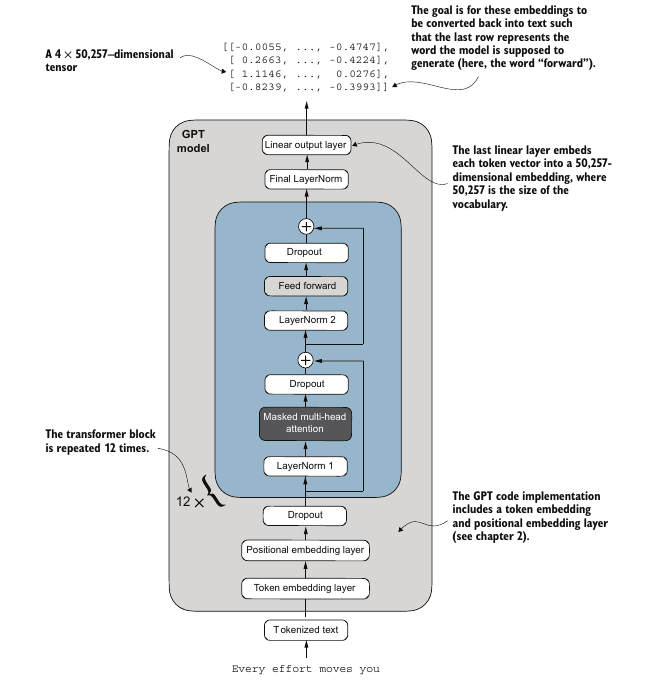
</div>